# Ensemble Models -1

In [1]:
using MLJ
import DataFrames
import Statistics
using PrettyPrinting
using StableRNGs

In [3]:
rng = StableRNG(512)
Xraw = rand(rng, 300, 3)

300×3 Matrix{Float64}:
 0.941503    0.721724   0.328143
 0.423794    0.0423568  0.449126
 0.181315    0.767096   0.252239
 0.788659    0.21882    0.318666
 0.473444    0.531495   0.275985
 0.85171     0.18371    0.640187
 0.141996    0.934331   0.0338421
 0.577308    0.0924971  0.771955
 0.0199241   0.700031   0.101959
 0.900477    0.246024   0.387603
 0.444832    0.509509   0.342469
 0.270885    0.468182   0.14166
 0.923804    0.513764   0.00783605
 ⋮                      
 0.548699    0.736581   0.747059
 0.579349    0.204345   0.111636
 0.654865    0.275287   0.3275
 0.590148    0.0713853  0.0290355
 0.256165    0.596071   0.483203
 0.00996852  0.722794   0.402213
 0.843964    0.378416   0.542911
 0.602174    0.321716   0.350327
 0.1297      0.0684328  0.90622
 0.821579    0.873053   0.0278195
 0.498559    0.278562   0.657468
 0.130187    0.0339702  0.152995

In [6]:
y = exp.(Xraw[:,1] - Xraw[:,2] - 2Xraw[:,3] + 0.1*rand(rng, 300))

300-element Vector{Float64}:
 0.672657356685761
 0.6523158955342817
 0.35899471060893334
 1.0211123286552908
 0.5660587732366503
 0.588372865019088
 0.4500460881879446
 0.35696757193445
 0.4391612293478602
 0.8946336850085883
 0.5085009635069928
 0.64407006202086
 1.6083381214283663
 ⋮
 0.18638145693080677
 1.2761854578790957
 0.8083286573032545
 1.63123801833386
 0.2964955041324386
 0.2420412659383037
 0.5523973026830723
 0.7195924524142018
 0.19150696098171055
 0.9788638274184188
 0.34204451954655674
 0.8378129356037269

In [7]:
X = DataFrames.DataFrame(Xraw);
train, tes = partition(eachindex(y),0.7);

In [13]:
using NearestNeighborModels

In [14]:
@load KNNRegressor

import NearestNeighborModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/sandhya/.julia/packages/MLJModels/E8BbE/src/loading.jl:168


KNNRegressor

In [15]:
knn_model = KNNRegressor(K=10)

KNNRegressor(
    K = 10,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = Uniform()) @667

In [16]:
knn = machine(knn_model, X, y)

Machine{KNNRegressor,…} @041 trained 0 times; caches data
  args: 
    1:	Source @329 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @604 ⏎ `AbstractVector{Continuous}`


In [18]:
MLJ.fit!(knn, rows = train)
y_pred = predict(knn, X[tes,:])
rms(y_pred, y[tes])

┌ Info: Not retraining Machine{KNNRegressor,…} @041. Use `force=true` to force.
└ @ MLJBase /home/sandhya/.julia/packages/MLJBase/pCCd7/src/machines.jl:345


0.06389980172436367

In [19]:
evaluate!(knn, resampling=Holdout(fraction_train=0.7, rng=StableRNG(666)),
          measure=rms) |> pprint

(measure = [RootMeanSquaredError @344],
 measurement = [0.12367388032666658],
 per_fold = [[0.12367388032666658]],
 per_observation = [missing],
 fitted_params_per_fold =
     [(tree =
           NearestNeighbors.KDTree{StaticArrays.SVector{3, Float64}, Euclidean, Float64}
  Number of points: 210
  Dimensions: 3
  Metric: Euclidean(0.0)
  Reordered: true,)],
 report_per_fold = [()])

## Homogenours ensumbles

MLJ offers basic support for ensembling such as bagging. Defining such an ensemble of simple "atomic" models is done via the EnsembleModel constructor:

In [21]:
ensumble_model = EnsembleModel(atom=knn_model, n=20)

DeterministicEnsembleModel(
    atom = KNNRegressor(
            K = 10,
            algorithm = :kdtree,
            metric = Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = Uniform()),
    atomic_weights = Float64[],
    bagging_fraction = 0.8,
    rng = Random._GLOBAL_RNG(),
    n = 20,
    acceleration = CPU1{Nothing}(nothing),
    out_of_bag_measure = Any[]) @195

In [23]:
ensemble = machine(ensumble_model, X, y)
estimates = evaluate!(ensemble, resampling=CV())
estimates |> pprint

Evaluating over 6 folds: 100%[=========================] Time: 0:00:03


(measure = [RootMeanSquaredError @344],
 measurement = [0.08533824428913264],
 per_fold = [[0.09305915717069502,
              0.11298540927426902,
              0.07634821910498125,
              0.08733998380754933,
              0.06530184724816686,
              0.0674413196926615]],
 per_observation = [missing],
 fitted_params_per_fold =
     [(fitresult =
           WrappedEnsemble{KNNResult{KDTree{SArray{Tuple,…},…},…},…} @066,),
      (fitresult =
           WrappedEnsemble{KNNResult{KDTree{SArray{Tuple,…},…},…},…} @406,),
      (fitresult =
           WrappedEnsemble{KNNResult{KDTree{SArray{Tuple,…},…},…},…} @646,),
      (fitresult =
           WrappedEnsemble{KNNResult{KDTree{SArray{Tuple,…},…},…},…} @284,),
      (fitresult =
           WrappedEnsemble{KNNResult{KDTree{SArray{Tuple,…},…},…},…} @023,),
      (fitresult =
           WrappedEnsemble{KNNResult{KDTree{SArray{Tuple,…},…},…},…} @887,)],
 report_per_fold = [(measures = [], oob_measurements = missing),
             

In [24]:
@show estimates.measurement[1]
@show mean(estimates.per_fold[1])

estimates.measurement[1] = 0.08533824428913264
mean(estimates.per_fold[1]) = 0.08374598938305383


0.08374598938305383

## Systematic tuning

Let's simultaneously tune the ensemble's bagging_fraction and the K-Nearest neighbour hyperparameter K. Since one of our models is a field of the other, we have nested hyperparameters:

In [26]:
params(ensumble_model) |> pprint

(atom = (K = 10,
         algorithm = :kdtree,
         metric = Euclidean(0.0),
         leafsize = 10,
         reorder = true,
         weights = Uniform()),
 atomic_weights = [],
 bagging_fraction = 0.8,
 rng = Random._GLOBAL_RNG(),
 n = 20,
 acceleration = CPU1{Nothing}(nothing),
 out_of_bag_measure = [])

In [28]:
B_range = range(ensumble_model, :bagging_fraction, lower=0.5, upper=1.0)
K_range = range(ensumble_model, :(atom.K), lower=1, upper=20)

typename(MLJBase.NumericRange)(Int64, :(atom.K), ... )

In [42]:
tm = TunedModel(model=ensumble_model,
                tuning=Grid(resolution=10), # 10x10 grid
                resampling=Holdout(fraction_train=0.8, rng=StableRNG(42)),
                ranges=[B_range, K_range])


┌ Info: No measure specified. Setting measure=RootMeanSquaredError @344. 
└ @ MLJTuning /home/sandhya/.julia/packages/MLJTuning/QFcuQ/src/tuned_models.jl:230


DeterministicTunedModel(
    model = DeterministicEnsembleModel(
            atom = KNNRegressor @667,
            atomic_weights = Float64[],
            bagging_fraction = 0.8,
            rng = Random._GLOBAL_RNG(),
            n = 20,
            acceleration = CPU1{Nothing}(nothing),
            out_of_bag_measure = Any[]),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.8,
            shuffle = true,
            rng = StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)),
    measure = RootMeanSquaredError(),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T[NumericRange{Float64,…} @888, NumericRange{Int64,…} @055],
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = nothing,
   

In [43]:
tuned_ensemble = machine(tm,X_mat,y)

Machine{DeterministicTunedModel{Grid,…},…} @412 trained 0 times; caches data
  args: 
    1:	Source @363 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @244 ⏎ `AbstractVector{Continuous}`


In [44]:
fit!(tuned_ensemble, rows=train);

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…} @412.
└ @ MLJBase /home/sandhya/.julia/packages/MLJBase/pCCd7/src/machines.jl:342
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/sandhya/.julia/packages/MLJTuning/QFcuQ/src/tuned_models.jl:600
Evaluating over 100 metamodels: 100%[=========================] Time: 0:00:00


## Reporting results

In [45]:
best_ensemble = fitted_params(tuned_ensemble).best_model
@show best_ensemble.atom.K
@show best_ensemble.bagging_fraction

best_ensemble.atom.K = 3
best_ensemble.bagging_fraction = 0.5


0.5

In [48]:
r = report(tuned_ensemble)

(best_model = DeterministicEnsembleModel{KNNRegressor} @977,
 best_history_entry = (model = DeterministicEnsembleModel{KNNRegressor} @977,
                       measure = [RootMeanSquaredError @344],
                       measurement = [0.04661701540793274],
                       per_fold = [[0.04661701540793274]],),
 history = NamedTuple{(:model, :measure, :measurement, :per_fold), Tuple{MLJ.DeterministicEnsembleModel{KNNRegressor}, Vector{RootMeanSquaredError}, Vector{Float64}, Vector{Vector{Float64}}}}[(model = DeterministicEnsembleModel{KNNRegressor} @720, measure = [RootMeanSquaredError @344], measurement = [0.0585281161198057], per_fold = [[0.0585281161198057]]), (model = DeterministicEnsembleModel{KNNRegressor} @860, measure = [RootMeanSquaredError @344], measurement = [0.07305403149992541], per_fold = [[0.07305403149992541]]), (model = DeterministicEnsembleModel{KNNRegressor} @321, measure = [RootMeanSquaredError @344], measurement = [0.22794995590009834], per_fold = [[0.227

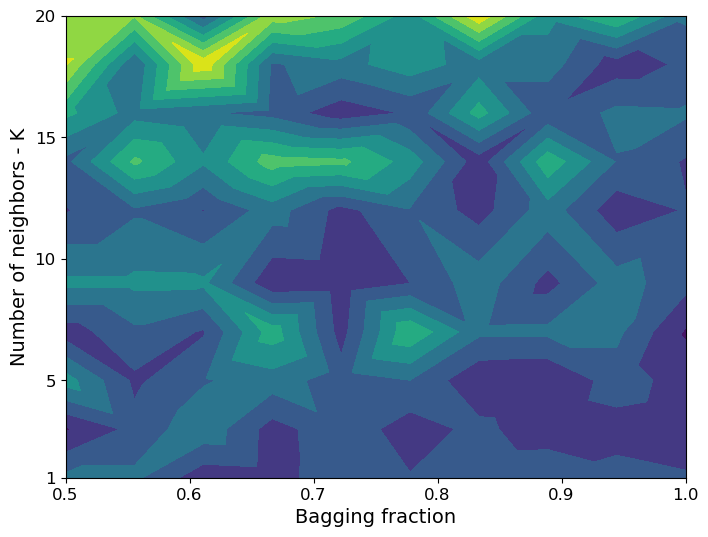

PyObject Text(29.00000000000002, 0.5, 'Number of neighbors - K')

In [47]:
using PyPlot

figure(figsize=(8,6))

res = r.plotting
vals_b = res.parameter_values[:, 1]
vals_k = res.parameter_values[:, 2]

tricontourf(vals_b, vals_k, res.measurements)
xticks(0.5:0.1:1, fontsize=12)
xlabel("Bagging fraction", fontsize=14)
yticks([1, 5, 10, 15, 20], fontsize=12)
ylabel("Number of neighbors - K", fontsize=14)

In [50]:
y_pred = predict(tuned_ensemble, rows=tes)
rms(y_pred, y[tes])

0.055802225897425714

# Ensemble Models - 2

This tutorial builds upon the previous ensemble tutorial with a home-made Random Forest regressor on the "boston" dataset.

In [52]:
using MLJ
using PyPlot
using PrettyPrinting
using StableRNGs
import DataFrames

In [53]:
X, y = @load_boston
sch = schema(X)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ Crim    │ Float64 │ Continuous │
│ Zn      │ Float64 │ Continuous │
│ Indus   │ Float64 │ Continuous │
│ NOx     │ Float64 │ Continuous │
│ Rm      │ Float64 │ Continuous │
│ Age     │ Float64 │ Continuous │
│ Dis     │ Float64 │ Continuous │
│ Rad     │ Float64 │ Continuous │
│ Tax     │ Float64 │ Continuous │
│ PTRatio │ Float64 │ Continuous │
│ Black   │ Float64 │ Continuous │
│ LStat   │ Float64 │ Continuous │
└─────────┴─────────┴────────────┘
_.nrows = 506


In [54]:
p = length(sch.names)

12

In [55]:
n = sch.nrows

506

In [56]:
@show (n, p)

(n, p) = (506, 12)


(506, 12)

In [57]:
DataFrames.describe(y)

Summary Stats:
Length:         506
Missing Count:  0
Mean:           22.532806
Minimum:        5.000000
1st Quartile:   17.025000
Median:         21.200000
3rd Quartile:   25.000000
Maximum:        50.000000
Type:           Float64


In [71]:
dtr = @load DecisionTreeRegressor pkg=DecisionTree

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/sandhya/.julia/packages/MLJModels/E8BbE/src/loading.jl:168


MLJDecisionTreeInterface.DecisionTreeRegressor

In [72]:
tree = machine(dtr(), X, y)

Machine{DecisionTreeRegressor,…} @492 trained 0 times; caches data
  args: 
    1:	Source @040 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @294 ⏎ `AbstractVector{Continuous}`


In [73]:
import MLJBase.evaluate!

In [77]:
e = evaluate!(tree, resampling=Holdout(fraction_train=0.8),
              measure=[rms, rmslp1])


┌───────────────────────────────────────────────────────────────┬───────────────
│ _.measure                                                     │ _.measuremen ⋯
├───────────────────────────────────────────────────────────────┼───────────────
│ RootMeanSquaredError @344                                     │ 7.06         ⋯
│ \eRootMeanSquaredLogProportionalError{Float64} @485\e │ 0.328        ⋯
└───────────────────────────────────────────────────────────────┴───────────────
                                                               2 columns omitted
_.per_observation = [missing, missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [78]:
e |> pprint # use PrettyPrinting

(measure = [RootMeanSquaredError @344,
            RootMeanSquaredLogProportionalError{Float64} @485],
 measurement = [7.060107887221603, 0.32761260327401803],
 per_fold = [[7.060107887221603], [0.32761260327401803]],
 per_observation = [missing, missing],
 fitted_params_per_fold = [(tree = Decision Tree
Leaves: 64
Depth:  13,)],
 report_per_fold = [nothing])

## Random forest

In [79]:
forest = EnsembleModel(atom=dtr())
forest.atom.n_subfeatures = 3

3

In [80]:
rng = StableRNG(5123) # for reproducibility
m = machine(forest, X, y)
r = range(forest, :n, lower=10, upper=1000)
curves = learning_curve!(m, resampling=Holdout(fraction_train=0.8, rng=rng),
                         range=r, measure=rms);

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…} @954.
└ @ MLJBase /home/sandhya/.julia/packages/MLJBase/pCCd7/src/machines.jl:342
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning /home/sandhya/.julia/packages/MLJTuning/QFcuQ/src/tuned_models.jl:600
Evaluating over 30 metamodels: 100%[=========================] Time: 0:00:48


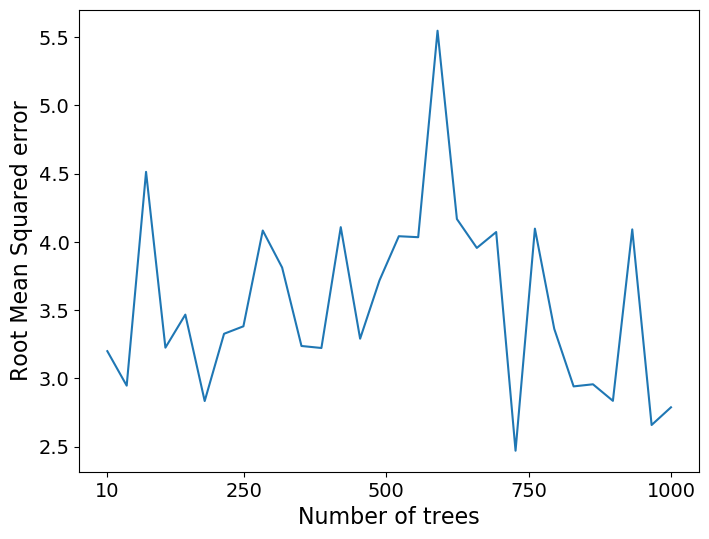

([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0], PyCall.PyObject[PyObject Text(0, 2.0, '2.0'), PyObject Text(0, 2.5, '2.5'), PyObject Text(0, 3.0, '3.0'), PyObject Text(0, 3.5, '3.5'), PyObject Text(0, 4.0, '4.0'), PyObject Text(0, 4.5, '4.5'), PyObject Text(0, 5.0, '5.0'), PyObject Text(0, 5.5, '5.5'), PyObject Text(0, 6.0, '6.0')])

In [81]:
##Plotting

figure(figsize=(8,6))
plot(curves.parameter_values, curves.measurements)
ylabel("Root Mean Squared error", fontsize=16)
xlabel("Number of trees", fontsize=16)
xticks([10, 250, 500, 750, 1000], fontsize=14)
yticks(fontsize=14)

In [83]:
forest.n = 150;

## Tuining

In [85]:
params(forest)  |> pprint

(atom = (max_depth = -1,
         min_samples_leaf = 5,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 3,
         post_prune = false,
         merge_purity_threshold = 1.0),
 atomic_weights = [],
 bagging_fraction = 0.8,
 rng = Random._GLOBAL_RNG(),
 n = 150,
 acceleration = CPU1{Nothing}(nothing),
 out_of_bag_measure = [])

In [86]:
r_sf = range(forest, :(atom.n_subfeatures), lower=1, upper=12)
r_bf = range(forest, :bagging_fraction, lower=0.4, upper=1.0);

In [87]:
tuned_forest = TunedModel(model=forest,
                          tuning=Grid(resolution=3),
                          resampling=CV(nfolds=6, rng=StableRNG(32)),
                          ranges=[r_sf, r_bf],
                          measure=rms)
m = machine(tuned_forest, X, y)
e = evaluate!(m, resampling=Holdout(fraction_train=0.8),
              measure=[rms, rmslp1])
e |> pprint

(measure = [RootMeanSquaredError @344,
            RootMeanSquaredLogProportionalError{Float64} @485],
 measurement = [3.931755412469539, 0.24628982791666806],
 per_fold = [[3.931755412469539], [0.24628982791666806]],
 per_observation = [missing, missing],
 fitted_params_per_fold =
     [(best_model =
           DeterministicEnsembleModel{DecisionTreeRegressor} @683,
       best_fitted_params =
           (fitresult = WrappedEnsemble{Node{Float64,…},…} @731,))],
 report_per_fold =
     [(best_model =
           DeterministicEnsembleModel{DecisionTreeRegressor} @683,
       best_history_entry =
           (model =
                DeterministicEnsembleModel{DecisionTreeRegressor} @683,
            measure = [RootMeanSquaredError @344],
            measurement = [3.636620358554623],
            per_fold = [[2.4400961925467746,
                         2.4469541861135014,
                         5.016379994904176,
                         4.064123733238112,
                         3.4305

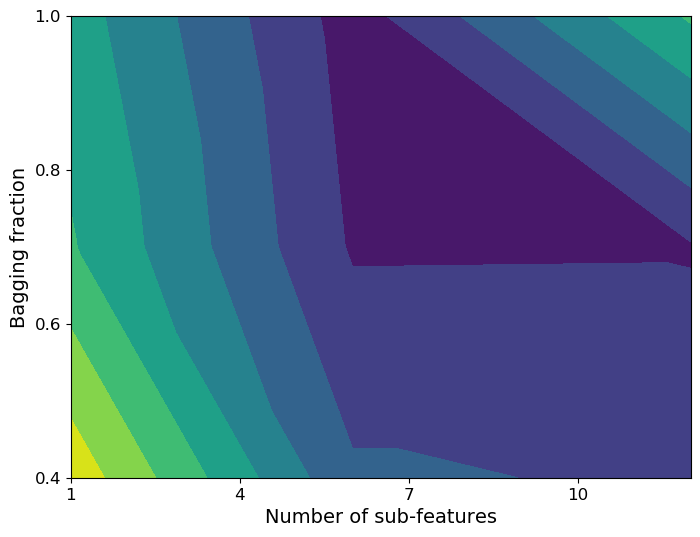

PyObject Text(29.000000000000007, 0.5, 'Bagging fraction')

In [88]:
r = report(m)

figure(figsize=(8,6))

res = r.plotting

vals_sf = res.parameter_values[:, 1]
vals_bf = res.parameter_values[:, 2]

tricontourf(vals_sf, vals_bf, res.measurements)
xticks(1:3:12, fontsize=12)
xlabel("Number of sub-features", fontsize=14)
yticks(0.4:0.2:1, fontsize=12)
ylabel("Bagging fraction", fontsize=14)

In [89]:
y_pred = predict(m, X)
rms(y_pred, y)

2.383558355177129

# Simple example of a homogeneous ensemble using learning networks

In this simple example, no bagging is used, so every atomic model gets the same learned parameters, unless the atomic model training algorithm has randomness, eg, DecisionTree with random subsampling of features at nodes.

Note that MLJ has a built in model wrapper called EnsembleModel for creating bagged ensembles with a few lines of code.

In [90]:
using MLJ
using PyPlot
import Statistics

In [91]:
Xs = source()
ys = source()


Source @844 ⏎ `Nothing`

In [131]:
atom = @load DecisionTreeRegressor() pkg=DecisionTree
#atom.n_subfeatures = 4 # to ensure diversity among trained atomic models
atom = atom(n_subfeatures = 4)
machines = (machine(atom, Xs, ys) for i in 1:100)

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/sandhya/.julia/packages/MLJModels/E8BbE/src/loading.jl:168


Base.Generator{UnitRange{Int64}, var"#44#45"}(var"#44#45"(), 1:100)

In [116]:
Statistics.mean(v...) = mean(v)
Statistics.mean(v::AbstractVector{<:AbstractNode}) = node(mean, v...)

yhat = mean([predict(m, Xs) for  m in machines])

Node{Nothing} @774
  args:
    1:	Node{Machine{DecisionTreeRegressor,…}} @561
    2:	Node{Machine{DecisionTreeRegressor,…}} @528
    3:	Node{Machine{DecisionTreeRegressor,…}} @693
    4:	Node{Machine{DecisionTreeRegressor,…}} @839
    5:	Node{Machine{DecisionTreeRegressor,…}} @615
    6:	Node{Machine{DecisionTreeRegressor,…}} @109
    7:	Node{Machine{DecisionTreeRegressor,…}} @055
    8:	Node{Machine{DecisionTreeRegressor,…}} @548
    9:	Node{Machine{DecisionTreeRegressor,…}} @013
    10:	Node{Machine{DecisionTreeRegressor,…}} @569
    11:	Node{Machine{DecisionTreeRegressor,…}} @672
    12:	Node{Machine{DecisionTreeRegressor,…}} @122
    13:	Node{Machine{DecisionTreeRegressor,…}} @895
    14:	Node{Machine{DecisionTreeRegressor,…}} @558
    15:	Node{Machine{DecisionTreeRegressor,…}} @298
    16:	Node{Machine{DecisionTreeRegressor,…}} @623
    17:	Node{Machine{DecisionTreeRegressor,…}} @760
    18:	Node{Machine{DecisionTreeRegressor,…}} @259
    19:	Node{Machine{DecisionTreeRegressor,…}}

In [132]:
surrogate = Deterministic()
mach = machine(surrogate, Xs, ys; predict=yhat)

@from_network mach begin
    mutable struct OneHundredModels
        atom=atom
    end
end

one_hundred_models = OneHundredModels()

OneHundredModels(
    atom = DecisionTreeRegressor(
            max_depth = -1,
            min_samples_leaf = 5,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 4,
            post_prune = false,
            merge_purity_threshold = 1.0)) @422

## Application to data

In [118]:
X, y = @load_boston;

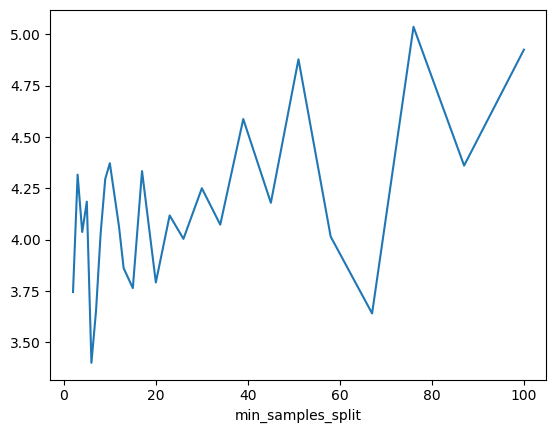

PyObject Text(0.5, 24.140625, 'min_samples_split')

In [133]:
r = range(atom,
          :min_samples_split,
          lower=2,
          upper=100, scale=:log)

mach = machine(atom, X, y)

curve = learning_curve!(mach,
                        range=r,
                        measure=mav,
                        resampling=CV(nfolds=9),
                        verbosity=0)

plot(curve.parameter_values, curve.measurements)
xlabel(curve.parameter_name)

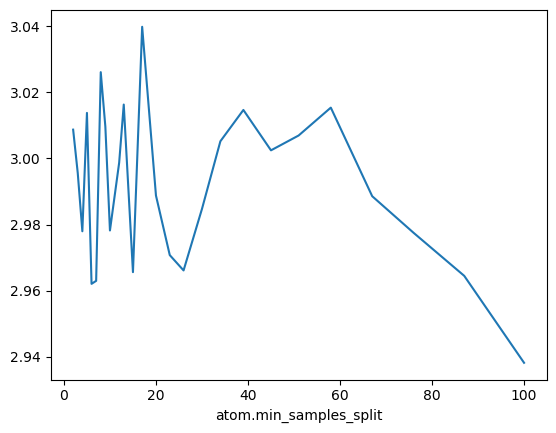

PyObject Text(0.5, 24.140625, 'atom.min_samples_split')

In [135]:
r = range(one_hundred_models,
          :(atom.min_samples_split),
          lower=2,
          upper=100, scale=:log)

mach = machine(one_hundred_models, X, y)

curve = learning_curve!(mach,
                        range=r,
                        measure=mav,
                        resampling=CV(nfolds=9),
                        verbosity=0)

plot(curve.parameter_values, curve.measurements)
xlabel(curve.parameter_name)